В ходе A/B–тестирования целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.
### Входные данные
4 csv-файла:
* __groups.csv__ - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)
* **groups_add.csv** - дополнительный файл с пользователями, который прислали спустя 2 дня после передачи данных
* **active_studs.csv** - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.
* __checks.csv__ - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [232]:
import pandas as pd
import numpy as np

import requests

from scipy.stats import norm 

import seaborn as sns
import matplotlib.pyplot as plt

import re

In [233]:
csv = [['groups.csv',';'], ['group_add.csv',','], ['active_studs.csv',','], ['checks.csv',';']]
for doc in csv:
    globals()[doc[0][:-4]] = pd.read_csv(doc[0], sep=doc[1])

#### Информация о содержимом файлов:

In [234]:
print(groups.head(), '\n')
print('Число уникальных ID:', groups.id.nunique(), '\n')
print(groups.info())


     id grp
0  1489   B
1  1627   A
2  1768   B
3  1783   B
4  1794   A 

Число уникальных ID: 74484 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB
None


In [235]:
print(group_add.head(), '\n')
print('Число уникальных ID:', group_add.id.nunique(), '\n')
print(group_add.info())

        id grp
0  5694584   B
1  5694830   B
2  5695057   B
3  5698872   B
4  5699067   B 

Число уникальных ID: 92 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB
None


In [236]:
print(active_studs.head(), '\n')
print('Число уникальных ID:', active_studs.student_id.nunique(), '\n')
print(active_studs.info())

   student_id
0      581585
1     5723133
2     3276743
3     4238589
4     4475369 

Число уникальных ID: 8341 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB
None


In [237]:
print(checks.head(), '\n')
print('Число уникальных ID:', checks.student_id.nunique(), '\n')
print(checks.info())

   student_id    rev
0        1627  990.0
1        3185  690.0
2       25973  690.0
3       26280  690.0
4      100300  990.0 

Число уникальных ID: 541 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB
None


#### Проверим учет groups_add в active_studs и checks:

In [238]:
print('в active_studs:', group_add.query('id in @active_studs.student_id').shape[0], ', а в checks:', 
      group_add.query('id in @checks.student_id').shape[0], 'пользователей из groups_add')

в active_studs: 13 , а в checks: 1 пользователей из groups_add


#### Соединим groups с group_add:

In [239]:
total_groups = pd.concat([groups, group_add])
print('До соединения:', groups.shape[0]+group_add.shape[0], 'строк')
print('После соединения:', total_groups.shape[0], 'строк')

До соединения: 74576 строк
После соединения: 74576 строк


#### Посмотрим на распределение пользователей по группам

In [240]:
print('Общее число пользователей в группе А:', total_groups.grp.value_counts()[1], ', в группе B:', total_groups.grp.value_counts()[0])
print('Число активных пользователей в группе А:', total_groups.query('id in @active_studs.student_id').grp.value_counts()[1], 
      ', в группе B:', total_groups.query('id in @active_studs.student_id').grp.value_counts()[0])
print('Число оплативших пользователей в группе А:', total_groups.query('id in @checks.student_id').grp.value_counts()[1], 
      ', в группе B:', total_groups.query('id in @checks.student_id').grp.value_counts()[0])

Общее число пользователей в группе А: 14693 , в группе B: 59883
Число активных пользователей в группе А: 1538 , в группе B: 6803
Число оплативших пользователей в группе А: 107 , в группе B: 434


In [241]:
print('Число активных пользователей, не входящих в общий список:', active_studs.query('student_id not in @total_groups.id').shape[0])
print('Число оплативших пользователей, не входящих в общий список:', checks.query('student_id not in @total_groups.id').shape[0])
print('Число оплативших пользователей, не входящих в список активных:', checks.query('student_id not in @active_studs.student_id').shape[0])
print('Число оплативших пользователей, не входящих в список активных в группе А:', total_groups.query('id not in @active_studs.student_id and id in @checks.student_id').grp.value_counts()[1],
     ', в группе B:', total_groups.query('id not in @active_studs.student_id and id in @checks.student_id').grp.value_counts()[0])

Число активных пользователей, не входящих в общий список: 0
Число оплативших пользователей, не входящих в общий список: 0
Число оплативших пользователей, не входящих в список активных: 149
Число оплативших пользователей, не входящих в список активных в группе А: 29 , в группе B: 120


##### Наличие платежей не от активных пользователей может быть связано либо c автоплатежами, либо с багом.
На число данных пользователей не влияет изменение механизма оплаты, так как они не заходили на платформу. Вследствие этого их можно не включать в выборки при проведении теста. __Оплатившими__ будем считать только __активных оплативших__:

In [242]:
checks_active = (
                active_studs
                .merge(checks, how='left', on='student_id')
                .rename(columns={'student_id': 'id'})
                )
checks_active.head()

,id,rev
0,581585,NaN
1,5723133,NaN
2,3276743,NaN
3,4238589,NaN
4,4475369,NaN


#### Теперь объединим всех активных оплативших с total_groups и оставим только активных.

In [243]:
active_total = total_groups.merge(checks_active, how='right', on='id')
active_total['payment'] = active_total.rev.apply(lambda x: 0 if np.isnan(x) else 1)
active_total.head()

,id,grp,rev,payment
0,581585,A,NaN,0
1,5723133,A,NaN,0
2,3276743,B,NaN,0
3,4238589,A,NaN,0
4,4475369,B,NaN,0


#### Очистим от NaN колонку с суммой оплаты. Заменим NaN на 0.

In [244]:
active_total['rev'] = active_total.rev.fillna(0)

In [245]:
a_active  = active_total.query('grp == "A"')

In [246]:
b_active  = active_total.query('grp == "B"')

In [247]:
a_active_paid = a_active.query('rev > 0')
a_active_paid.head()

,id,grp,rev,payment
62,1184303,A,1530.0,1
99,720651,A,1980.0,1
306,4337103,A,580.0,1
392,332387,A,2910.0,1
439,1659434,A,690.0,1


In [248]:
b_active_paid = b_active.query('rev > 0')
b_active_paid.head()

,id,grp,rev,payment
67,3354191,B,1900.0001,1
77,3278734,B,1900.0000,1
193,1232221,B,1900.0000,1
195,3821501,B,1900.0000,1
211,1036096,B,1900.0000,1


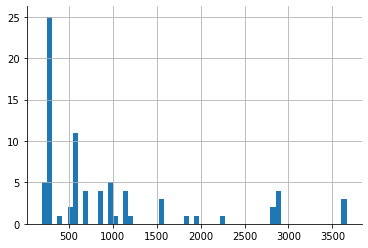

In [249]:
a_active_paid.rev.hist(bins=60)
sns.despine()

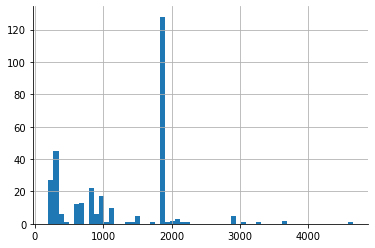

In [250]:
b_active_paid.rev.hist(bins=60)
sns.despine()

In [251]:
a_inf=a_active.rev.describe().to_frame().rename(columns={'rev':'group A'})
b_inf=b_active.rev.describe().to_frame().rename(columns={'rev':'group B'})
pd.concat([a_inf, b_inf],axis=1)

,group A,group B
count,1538.000000,6803.000000
mean,47.347204,58.058798
std,290.490632,313.770201
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,3660.000000,4650.000000


In [252]:
a_inf_paid=a_active_paid.rev.describe().to_frame().rename(columns={'rev':'group A'})
b_inf_paid=b_active_paid.rev.describe().to_frame().rename(columns={'rev':'group B'})
pd.concat([a_inf_paid, b_inf_paid],axis=1)

,group A,group B
count,78.000000,314.000000
mean,933.589744,1257.878992
std,919.932711,790.864254
min,199.000000,199.000000
25%,290.000000,511.750000
50%,585.000000,1140.000000
75%,1114.750000,1900.000000
max,3660.000000,4650.000000


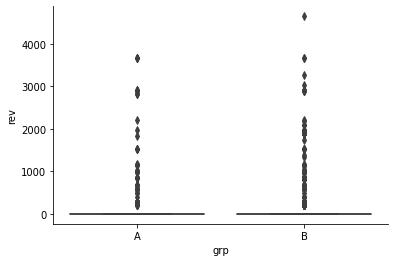

In [253]:
sns.boxplot(data=active_total, y='rev', x='grp')
sns.despine()

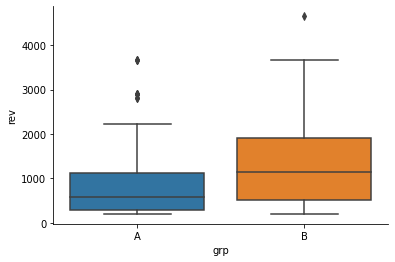

In [254]:
active_total_paid = active_total.query('rev > 0')
sns.boxplot(data=active_total_paid, y='rev', x='grp')
sns.despine()

#### Для анализа эффекта изменения процесса оплаты стоит обратить внимание на следующие метрики:
* __CR__ - конверсия в платеж (отношение пользователей, совершивших оплату, к общему числу активных пользователей).
Существенная разница между значениями данного показателя у сравниваемых групп может означать, что изменение метода оплаты влияет на выбор пользователя. Большее значение метрики может отвечать, например, более удобному и простому механизму.
* __ARPU__ - средний доход на пользователя (Чем выше этот показатель, тем эффективнее бизнес)
* __ARPPU__ - средний доход на платящего пользователя (аналогично)

In [255]:
CRa = round(a_active_paid.id.nunique()/a_active.id.nunique(), 4)*100
CRb = round(b_active_paid.id.nunique()/b_active.id.nunique(), 4)*100
deltaCR = round((CRb-CRa)/CRa*100, 1)
print('CR\n группы A:', CRa, '%\n', 
      'группы B:', CRb, '%\n')
print('Конверсия группы В на', abs(deltaCR), '%', 'меньше конверсии группы А' if deltaCR < 0 else 'больше конверсии группы А')

CR
 группы A: 5.07 %
 группы B: 4.62 %

Конверсия группы В на 8.9 % меньше конверсии группы А


In [256]:
ARPUa = round(a_active_paid.rev.sum()/a_active.id.nunique(), 2)
ARPUb = round(b_active_paid.rev.sum()/b_active.id.nunique(), 2)
deltaARPU = round((ARPUb-ARPUa)/ARPUa*100, 2)
print('ARPU\n группы A:', ARPUa, '\n', 
      'группы B:', ARPUb, '\n')
print('Средний доход на пользователя в группе В на', abs(deltaARPU), '%', 'меньше, чем в группе А' if deltaARPU < 0 else 'больше, чем в группе А')

ARPU
 группы A: 47.35 
 группы B: 58.06 

Средний доход на пользователя в группе В на 22.62 % больше, чем в группе А


In [257]:
ARPPUa = round(a_active_paid.rev.sum()/a_active_paid.id.nunique(), 2)
ARPPUb = round(b_active_paid.rev.sum()/b_active_paid.id.nunique(), 2)
deltaARPPU = round((ARPPUb-ARPPUa)/ARPPUa*100, 2)
print('ARPU\n группы A:', ARPPUa, '\n', 
      'группы B:', ARPPUb, '\n')
print('Средний доход на платящего пользователя в группе В на', abs(deltaARPPU), '%', 'меньше, чем в группе А' if deltaARPPU < 0 else 'больше, чем в группе А')

ARPU
 группы A: 933.59 
 группы B: 1257.88 

Средний доход на платящего пользователя в группе В на 34.74 % больше, чем в группе А


#### На основании полученных результатов видно, что конверсия целевой группы упала, однако средний доход на пользователя/покупателя увеличился. Значит, в целевой группе вырос средний чек.

#### Проверка различий на статистическую значимость

Так как размеры групп сильно различаются, применение классических критериев затруднительно. В этом случае хорошо подходит Bootstrap.

In [258]:
def get_bootstrap(
    data_column_1,                       # значения контрольной выборки
    data_column_2,                       # значения тестовой выборки
    boot_it   = 1000,                    # количество бутстрэп-подвыборок
    statistic = np.mean,                 # интересующая статистика
    bootstrap_conf_level = 0.95,         # уровень значимости
    graph         = True,                # отрисовка графика
    ):
    boot_len  = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    
        
    for i in range(boot_it):       
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True                        # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        samples_delta = samples_2 - samples_1      # находим разницу подвыборок
        boot_data.append(statistic(samples_delta)) # применяем статистику для разниц подвыборок
        
    pd_boot_data = pd.DataFrame(boot_data)

    # доверительный интервал 
    left_quant  = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x     = 0, 
        loc   = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x     = 0, 
        loc   = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # отисовка графиков
    if graph == True:
        plt.hist(pd_boot_data[0], bins = 50)
        plt.style.use('ggplot')
        plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
        plt.xlabel('boot_data')
        plt.ylabel('frequency')
        plt.title("Histogram of boot_data")
        plt.show()
       
    return {"ci": ci, 
            "p_value": p_value}

In [263]:
def cr_func(x):             # Передаем серию со значениями 1(был платеж) и 0(не было)
    
    return sum(x) / len(x)

def arpu_func(y):
    
    return np.mean(y)

def arppu_func(y):          # Передаем серию только с платежами
    
    return np.mean(y)

### CR
* __H0__: CR групп мало различаются
* __H1__: CR групп разные

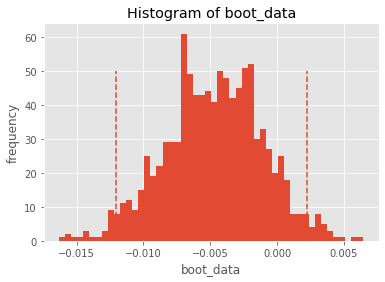

{'ci':               0
 0.025 -0.012054
 0.975  0.002209,
 'p_value': 0.19434384125101833}

In [269]:
 get_bootstrap(a_active.payment, b_active.payment, statistic = cr_func)

#### Так как нулевое значение попадает в доверительный интервал, то нельзя отвергать нулевую гипотезу и предполагать, что между группами есть отличие в CR. 

### ARPU
* __H0__: ARPU обеих групп мало различаются
* __H1__: ARPU различны

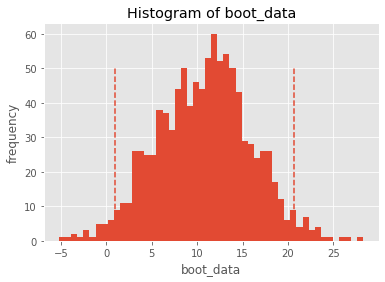

{'ci':                0
 0.025   0.936404
 0.975  20.719628,
 'p_value': 0.03575507300622527}

In [275]:
 get_bootstrap(a_active.rev, b_active.rev, statistic = arpu_func)

#### Ноль не попадает в доверительный интервал, следовательно, нулевая гипотеза отвергается. Различия в значениях ARPU статистически значимы.

### ARPPU
* __H0__: ARPPU обеих групп мало различаются
* __H1__: ARPPU различны

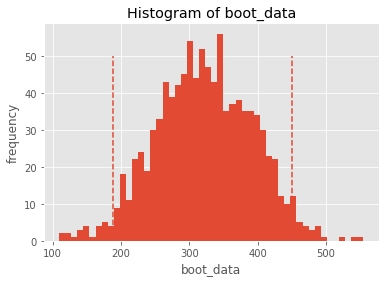

{'ci':                 0
 0.025  187.700089
 0.975  450.165535,
 'p_value': 4.598001548963228e-06}

In [282]:
get_bootstrap(a_active.rev[a_active.rev>0], b_active.rev[b_active.rev>0], statistic = arppu_func)

#### Ноль не попал в доверительный интервал, нулевая гипотеза отвергается. Различия в значениях ARPPU статистически значимы.

### Новый механизм стоит применить и для контрольной группы, т.к. статистически различия в CR не подтвердились, а, значит, уменьшение CR тестовой группы незначительно. А вот увеличение среднего дохода на пользователя/покупателя для нового механизма оказывается, наоборот, значимым. 